# Реализация DQN

В этом уроке мы разберем на практике обучение DQN (Deep Q Network) для задачи Pong.

### Загрузка библиотек

Для обучения нейросети будем использовать TensorFlow

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import gym
from gym.wrappers import Monitor

import tensorflow as tf

In [ ]:
!conda install gym[atari]

In [ ]:
!pip3 install gym[atari]

In [ ]:
!pip install autorom
!AutoROM --accept-license

In [ ]:
!ale-import-roms /home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/AutoROM/roms/

### Создание игровой среды
Создадим симулятор Pong.

In [2]:
env = gym.make('Pong-v0')

STATE_SHAPE = env.observation_space.shape
NUM_ACTIONS = env.action_space.n
ACTION_MEANING = env.unwrapped.get_action_meanings()

print('States shape: {}'.format(STATE_SHAPE))
print('Actions: {}'.format(NUM_ACTIONS))
print('Actions: {}'.format(ACTION_MEANING))

States shape: (210, 160, 3)
Actions: 6
Actions: ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


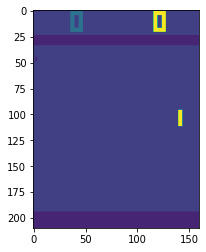

In [3]:
s = env.reset()
j = 0
_=plt.imshow(s[:,:,2])

(160, 160)


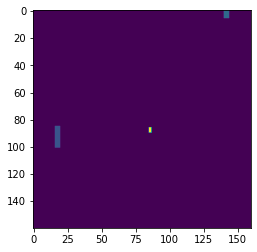

In [139]:
print(s[34:194,:,2].shape) # можно обрезать
_=plt.imshow(s[34:194,:,2])

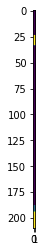

In [15]:
_=plt.imshow(s1[:,141:143,2]) # местоположение игрока

шаг 1
3
3
2
3
2
2
2
2
2
2
Reward:  0.0
Done?  False


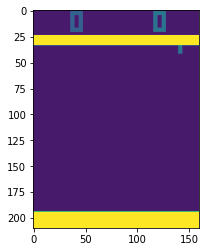

In [4]:
#a = env.action_space.sample()
j += 1 # счетчик

print(f'шаг {j}')

for i in range(10):
  a = int(np.random.rand()*2) + 2 # действие 2 или 3
  print(a)
  env.step(a)
  s1, r, done, _ = env.step(a)
print('Reward: ', r)
print('Done? ', done)
_=plt.imshow(s1[:,:,2])

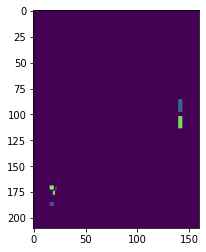

In [7]:
s = s1
s1, r, done, _ = env.step(a)
_=plt.imshow((s-s1)[:,:,2])

### Создание модели



In [18]:
#States shape: (210, 160, 3)

DIM = 32 # пробовал до 64
model = tf.keras.Sequential([
    #tf.keras.layers.Conv2D(16, (3, 3), padding='same', activation='relu', use_bias=False),
    tf.keras.layers.MaxPool2D((4, 4)),
    #tf.keras.layers.Conv2D(DIM, (8, 8), padding='same', activation='relu', use_bias=False, strides=(4,4)),
    #tf.keras.layers.Conv2D(DIM*2, (4, 4), padding='same', activation='relu', use_bias=False, strides=(2,2)),
    #tf.keras.layers.Conv2D(DIM*2, (3, 3), padding='same', activation='relu', use_bias=False, strides=(1,1)),
    #tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Conv2D(DIM/2, (3, 3), padding='same', activation='relu', use_bias=False, strides=(2,2)),                        
    #tf.keras.layers.MaxPool2D((2, 2)),
    #tf.keras.layers.Conv2D(DIM*4, (3, 3), padding='same', activation='relu', use_bias=False),                       
    #tf.keras.layers.MaxPool2D((2, 2)),
    #tf.keras.layers.Conv2D(DIM*4, (3, 3), padding='same', activation='relu', use_bias=False),                       
    #tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Conv2D(DIM*2, (20, 20), padding='valid', activation='relu', use_bias=False),
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dense(128, activation='relu', kernel_initializer=tf.initializers.RandomUniform(0, 1),
    #                      ),    
    #tf.keras.layers.Dense(128, activation='relu', kernel_initializer=tf.initializers.RandomUniform(0, 1),),
    #tf.keras.layers.Dense(16, activation='relu', kernel_initializer=tf.initializers.RandomUniform(0, 1),
    #                      use_bias=False),
    #tf.keras.layers.Lambda(lambda x: x * 0.9), # получались результаты очень близкие к 1
    tf.keras.layers.Dense(2, kernel_initializer=tf.initializers.RandomUniform(0, 1), #activation='tanh',
                          use_bias=False) # NUM_ACTIONS
])

#model.build((None, 210, 160, 1))
inp = s1[34:194,:,2].reshape(160,160,1) # берем один канал
model(np.array([inp/255], dtype=np.float32))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_pooling2d_8 (MaxPooling2 (1, 40, 40, 1)            0         
_________________________________________________________________
conv2d_12 (Conv2D)           (1, 20, 20, 16)           144       
_________________________________________________________________
conv2d_13 (Conv2D)           (1, 1, 1, 64)             409600    
_________________________________________________________________
flatten_6 (Flatten)          (1, 64)                   0         
_________________________________________________________________
dense_10 (Dense)             (1, 2)                    128       
Total params: 409,872
Trainable params: 409,872
Non-trainable params: 0
_________________________________________________________________


In [19]:
x= np.random.uniform(0,1,size=(210, 160, 3))
evalQ(x)

array([0.01045604, 0.00839373], dtype=float32)

In [ ]:
evalQ(s1-s)

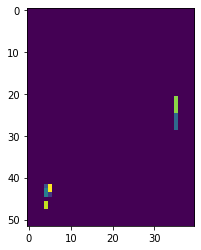

In [8]:
inp = (s1-s)[:,:,2].reshape(210,160,1) # что видит модель
inp =  tf.constant([inp], dtype=tf.int32)
conv = tf.keras.layers.MaxPool2D((4, 4))
out = conv(inp)
_=plt.imshow(out[0])

### Параметры обучения

* `lr` - скорость обучения (в теории это был параметр `alpha`)
* `gamma` - параметр дисконтирования
* `NUM_EPISODES` - сколько всего эпизодов игры будем осуществлять
* `MAX_STEPS` - максимальное количесвто шагов в рамках одного эпизода. Эпизод может закончиться и раньше. Это ограничение нужно, если агент зашёл в какой-то тупик и там застрял. Или для бесконечных игр/симуляций.

Кроме того, будем смотреть на награду, усреднённую в некотором временнОм окне (окно по эпизодам).

* `REWARD_AVERAGE_WINDOW` - размер этого окна.

In [5]:
lr = 0.001 # learning rate
gamma = 0.95 # параметр дисконтирования. уменьшил, важны последние 10-20 действий

NUM_EPISODES = 2000 # число эпизодов для обучения
MAX_STEPS = 50000 # максимальное число шагов в эпизоде

REWARD_AVERAGE_WINDOW = 25 # окно для усреднения наград по эпизодам

### Подготовка к обучению

В качестве функции потерь будем использовать квадрат нормы разницы между целевым и предсказанным вектором Q(s, :), как это обычно делается в задачах регрессии (ведь нам нужно притянуть друг к другу эти два вектора). Зададим это функцией `loss()`

В качестве оптимизатора для нейросети будем использовать SGD.

In [18]:
def loss(q1, q2):
    return tf.reduce_sum(tf.square(q1 - q2)) # tf.square(

#optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr)
model.compile(loss=loss, optimizer=optimizer)

# Experience replay

Обучение DQN во многом похоже на табличный Q-Learning. Рассмотрим подробнее лишь те части, котороые отличаются.

Чтобы получить значения Q-функции для текущего состояния `s` и всех действий, воспользуемся функцией `evalQ`: 

`Q_s = evalQ(s)`

Во время обучения будем использовать eps-greedy подход для выбора действия (в зависимости от параметра `eps` выбирать случайное действие или по текущей политике).

Самое интересное -- как сделать обновление Q-функции. Для начала, надо разобраться, как получить целевой вектор Q-target. Вспомним, что в Q-Learning мы должны обновить только значение `Q(s, a)` (через уравнение Беллмана). Но так как нейросеть предсказывает веткор для всех возможных действий (`Q(s, :)`), сделать нужно следующим образом.

 Пусть целевой вектор для `Q(s, :)` будет равен исходным (предсказанным нейросетью) значениям для всех действий, кроме действия `a`. То есть скопируем в `Q_target` текущий предсказанный `Q_s` и заменим в нём лишь `Q_target[a]` на та, что дает нам Беллман. И теперь наша задача "обучить" нейросеть на этот целевой вектор, то есть заставить её изменить свои веса так, чтобы только значение для действия `a` изменилось, а остальные значения `Q(s, :)` по возможности не изменялись. Делаем это через минимизацию ошибки между этими векторами.

А чтобы сделать один шаг минимизации ошибки, нам надо сделать один шаг градиентного спуска (или в общем случае один шаг обучения модели). Сделать это можно с помощью функции `model.train_on_batch(...)`, которая делает шаг обучения на данном батче. На входе у неё батч входов и батч правильных ответов. У нас будет батч из одного элемента.

В остальном всё то же самое, как было в Q-Learning.

И еще дополнительно накапливаем список "усредненных в окне наград" -- `totalRewardAverageList`

In [ ]:
from random import sample
import sys
import time

MINI_BATCH_LEN = 128 #128
REPLAY_BUFFER_LEN = MINI_BATCH_LEN * 100
LEARNING_STEP = MINI_BATCH_LEN # / 2
STUCK_PENALTY = -0.3
GT_AVG_WINDOW = REWARD_AVERAGE_WINDOW * 10 # окно для усреднения наград по эпизодам

pathLenList = [] # длины траекторий по эпизодам
totalRewardList = [] # суммарные награды по эпизодам
totalRewardAverageList = [] # суммарные награды по эпизодам (среднее по окну)

def evalQ(s):
    inp = s[34:194,:,2].reshape(160,160,1) # берем один канал
    inp = np.array([inp/255], dtype=np.float32)
    return model(inp).numpy()[0]

def evalQ_batch(s): # инференс батчем
    inp = s[:,34:194,:,2].reshape(-1,160,160,1) # берем один канал
    inp = np.array(inp/255, dtype=np.float32)
    return model(inp).numpy()

def stuck_penalty(s_list, s, s1, r):                # штрафую залипание у края
    if np.array_equal(s1[:,141:142,2], s[:,141:142,2]) and r == 0: 
        r = STUCK_PENALTY
        #s_list.append(s)
        #print(step)
    return r    

def update_q(step, sars_list): # обучение модели
  
  mbatch_indx = [i for i in range(len(sars_list))]
  mbatch_indx = sample(mbatch_indx, MINI_BATCH_LEN) # random indxs
    
  sars_list = np.array(sars_list)
  sars_list = sars_list[mbatch_indx]
  
  s = np.stack(sars_list[:,0], axis=0).astype('float') # получаем список s
  s1 = np.stack(sars_list[:,4], axis=0).astype('float') 

  Q_target = np.stack(sars_list[:, 1], axis=0).astype('float') # Новое (целевое) значение Q-функции
  a = sars_list[:, 2].astype('int')
  r = sars_list[:, 3].astype('float')
  #done = sars_list[:, 5]

  #return s1
  Q_s1 = evalQ_batch(s1)                      # тут s1 - s

  mask = np.where((r == 1) | (r == -1), True, False) # если пропустил/забил, обнуляем Q_s1
  Q_s1[mask] = 0

  Q_target[range(len(Q_target)), a] = r + gamma * np.amax(Q_s1, axis = 1) # линал магия

  if False:
    print('i =', i)
    print('Qs ', Q_target)
    print('Q_s1: ', Q_s1)
    print('a ', a)
    print(r)
    print('done ', done)    
    print('Q_target', Q_target)      

  inp = s[:,34:194,:,2].reshape(-1,160,160,1) # берем один канал, кропим
  inp = np.array(inp/255, dtype=np.float32)  

    # Обновление Q-функции
  history = model.train_on_batch(inp, Q_target)
  
  return history
        
def train_dqn(eps_del, TWO_STEP = True):                  # основной цикл
    """ обучение DQN, TWO_STEP - делать два одинаковых шага """
    
    sars_list = []
    mbatch_indx = []
    s_list = []
    avg_step_list = [] 
    filter_list = []
    replay_buf = []
    
    for i in range(NUM_EPISODES): #NUM_EPISODES): 

        eps = (1.0 - i / NUM_EPISODES) * eps_del

        s = env.reset()
        s0 = s            # предыдущее состояние

        totalReward = 0
        step = 0
        a_list = []

        while step < MAX_STEPS: #MAX_STEPS
            step += 1

            Q_s = evalQ(s- s0) # посылаем разницу между кадрами

            if np.random.rand() < eps: # действий всего 2, изучать особо нечего
                # Выбор случайного действия
                a = int(np.random.rand()*2) + 2 # действие 2 или 3
            else:
                # Выбор действия по текущей политике
                a = np.argmax(Q_s) + 2

            # Сделать шаг
            a_list.append(a)

            s1, r, done, _ = env.step(a)
            totalReward += r
            
            r = stuck_penalty(s_list, s, s1, r)       # штрафую залипание у края
            
            if TWO_STEP: #np.random.rand() < eps: # повторяем действие      
              if (not done) and (r == 0):         # Если предыдущее действие не привело к концу эпизода      
                s1, r, done, _ = env.step(a)                
                step += 1
                totalReward += r
                r = stuck_penalty(s_list, s, s1, r)      # штрафую залипание у края
                sars_list.append((s-s0, Q_s, a-2, r, s1-s, done)) # записываем результаты второго шага
              else:
                sars_list.append((s-s0, Q_s, a-2, r, s1-s, done)) # записываем результаты первого шага
               
              list_len = len(sars_list)
              if len(replay_buf) > (MINI_BATCH_LEN*2) and (list_len % LEARNING_STEP == 0): 
                s11 = update_q(step, replay_buf)
                                
            else:                                      #  не TWO_STEP
                sars_list.append((s-s0, Q_s, a-2, r, s1-s, done)) # записываем результаты
                if (len(sars_list)>(MINI_BATCH_LEN*2)) and (step % LEARNING_STEP == 0):
                    s11 = update_q(step, replay_buf)            

            s0 = s.copy()
            s = s1.copy()

            # Если конец эпизода
            if done:
                print(f'{i} rew= {totalReward} step {step} mean a {np.mean(a_list):.2f}')
                avg_step_list.append(step)
                replay_buf += sars_list
                sars_list = []
                time.clock()
                break

        pathLenList.append(step)
        totalRewardList.append(totalReward)
        
        if len(replay_buf) > REPLAY_BUFFER_LEN:
              replay_buf = replay_buf[int(REPLAY_BUFFER_LEN*0.2):] # убираем 20% из начала

        if i % REWARD_AVERAGE_WINDOW == 0 and i >= REWARD_AVERAGE_WINDOW:
            totalRewardAverage = np.mean(totalRewardList[-REWARD_AVERAGE_WINDOW:])
            step_average = np.mean(avg_step_list[-REWARD_AVERAGE_WINDOW:])        
            totalRewardAverageList.append(totalRewardAverage)
            print(f'Episode {i}: average total reward = {totalRewardAverage} avg step = {step_average}')
            print(evalQ(replay_buf[-5][0]))
            filter_list.append(np.mean(model.layers[1].get_weights()))
            if len(filter_list) > 3:
                print(f'current W: {filter_list[-1]}')
                print(filter_list[-1]-filter_list[-2])
                print(filter_list[-1]-filter_list[-3])
            
    
    totalRewardAverage = np.mean(totalRewardList[-GT_AVG_WINDOW:])
    step_average = np.mean(avg_step_list[-GT_AVG_WINDOW:]) 
    print(f'Last {GT_AVG_WINDOW} ep. average total reward = {totalRewardAverage} avg step = {step_average}')
    print(f'Last {GT_AVG_WINDOW} ep. max reward = {np.max(totalRewardList[-GT_AVG_WINDOW:])}')
    print(f'Last {GT_AVG_WINDOW} ep. max step = {np.max(avg_step_list[-GT_AVG_WINDOW:])}')
    
    return s11       

#s11 = train_dqn(1)
#s11

### Обучение DQN

In [ ]:
import time

for i in range(len(s11)):
    _=plt.imshow(s11[i])
    plt.show()
    time.sleep(0.5)

In [27]:
s11

array([0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0], dtype=object)

In [30]:
model.optimizer.learning_rate = 0.001
gamma = 0.95

train_dqn(1)

<ipython-input-25-e1c84e8d79c8>:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  sars_list = np.array(sars_list)


0 rew= -21.0 step 1603 mean a 2.49
1 rew= -19.0 step 1611 mean a 2.50
2 rew= -19.0 step 1668 mean a 2.50
3 rew= -20.0 step 1147 mean a 2.48
4 rew= -21.0 step 1335 mean a 2.50
5 rew= -21.0 step 1438 mean a 2.50
6 rew= -21.0 step 1594 mean a 2.53
7 rew= -21.0 step 1250 mean a 2.51
8 rew= -21.0 step 1106 mean a 2.51
9 rew= -21.0 step 1191 mean a 2.49
10 rew= -21.0 step 1199 mean a 2.50
11 rew= -21.0 step 1191 mean a 2.46
12 rew= -18.0 step 1906 mean a 2.49
13 rew= -21.0 step 1498 mean a 2.52
14 rew= -21.0 step 1112 mean a 2.48
15 rew= -19.0 step 1432 mean a 2.49
16 rew= -21.0 step 1426 mean a 2.50
17 rew= -21.0 step 1278 mean a 2.53
18 rew= -21.0 step 1188 mean a 2.51
19 rew= -21.0 step 1248 mean a 2.51
20 rew= -21.0 step 1341 mean a 2.51
Episode 20: average total reward = -20.5 avg step = 1357.95
[-1.0318617 -0.9865351]
21 rew= -21.0 step 1688 mean a 2.54
22 rew= -18.0 step 1558 mean a 2.50
23 rew= -20.0 step 1384 mean a 2.51
24 rew= -19.0 step 1419 mean a 2.49
25 rew= -21.0 step 1183 me

1.3801015615463257

In [31]:
model.save('dql 2d.mdl')

INFO:tensorflow:Assets written to: dql 2d.mdl/assets


## 2 этап

In [7]:
def loss(q1, q2):
    return tf.reduce_sum(tf.square(q1 - q2))

model = tf.keras.models.load_model('dql 2d.mdl', custom_objects={'loss': loss})

In [8]:
NUM_EPISODES = 2000 # число эпизодов для обучения

train_dqn(0)

<ipython-input-6-e1c84e8d79c8>:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  sars_list = np.array(sars_list)


0 rew= -20.0 step 1965 mean a 2.51
1 rew= -21.0 step 1420 mean a 2.51
2 rew= -21.0 step 1177 mean a 2.51
3 rew= -20.0 step 1787 mean a 2.52
4 rew= -20.0 step 1973 mean a 2.53
5 rew= -21.0 step 2000 mean a 2.53
6 rew= -20.0 step 1233 mean a 2.50
7 rew= -18.0 step 1720 mean a 2.55
8 rew= -19.0 step 1355 mean a 2.53
9 rew= -19.0 step 1920 mean a 2.47
10 rew= -21.0 step 2461 mean a 2.53
11 rew= -16.0 step 1985 mean a 2.52
12 rew= -21.0 step 1337 mean a 2.51
13 rew= -18.0 step 2292 mean a 2.51
14 rew= -19.0 step 1770 mean a 2.51
15 rew= -21.0 step 1835 mean a 2.52
16 rew= -21.0 step 1911 mean a 2.48
17 rew= -19.0 step 1765 mean a 2.53
18 rew= -19.0 step 1914 mean a 2.51
19 rew= -19.0 step 2380 mean a 2.51
20 rew= -20.0 step 1787 mean a 2.52
Episode 20: average total reward = -19.65 avg step = 1801.1
[-0.62299794 -0.66304034]
21 rew= -20.0 step 1706 mean a 2.52
22 rew= -21.0 step 1846 mean a 2.45
23 rew= -21.0 step 1330 mean a 2.53
24 rew= -18.0 step 1808 mean a 2.52
25 rew= -18.0 step 2290 

0.5061699151992798

In [9]:
model.save('dql 4k.mdl')

INFO:tensorflow:Assets written to: dql 4k.mdl/assets


In [8]:
def loss(q1, q2):
    return tf.reduce_sum(tf.square(q1 - q2))

model = tf.keras.models.load_model('dql 4k.mdl', custom_objects={'loss': loss})

In [9]:
NUM_EPISODES = 3000 # число эпизодов для обучения
model.optimizer.learning_rate = 0.001 # 0.005 не пошел

train_dqn(0)

model.save('dql 5k.mdl')

<ipython-input-7-99ba81ce6a32>:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  sars_list = np.array(sars_list)


0 rew= -20.0 step 2521 mean a 2.50
1 rew= -21.0 step 2343 mean a 2.50
2 rew= -20.0 step 2780 mean a 2.50
3 rew= -19.0 step 2654 mean a 2.51
4 rew= -18.0 step 2361 mean a 2.51
5 rew= -20.0 step 2364 mean a 2.50
6 rew= -19.0 step 2094 mean a 2.50
7 rew= -20.0 step 2356 mean a 2.50
8 rew= -21.0 step 1514 mean a 2.51
9 rew= -21.0 step 1500 mean a 2.51
10 rew= -19.0 step 2174 mean a 2.51
11 rew= -18.0 step 2183 mean a 2.51
12 rew= -18.0 step 2797 mean a 2.50
13 rew= -21.0 step 2156 mean a 2.50
14 rew= -18.0 step 2430 mean a 2.51
15 rew= -20.0 step 1717 mean a 2.51
16 rew= -20.0 step 2112 mean a 2.51
17 rew= -20.0 step 2816 mean a 2.52
18 rew= -20.0 step 1884 mean a 2.51
19 rew= -20.0 step 2031 mean a 2.52
20 rew= -21.0 step 1756 mean a 2.52
21 rew= -19.0 step 2308 mean a 2.51
22 rew= -18.0 step 2133 mean a 2.51
23 rew= -19.0 step 2249 mean a 2.51
24 rew= -19.0 step 2727 mean a 2.51
25 rew= -21.0 step 1339 mean a 2.51
Episode 25: average total reward = -19.6 avg step = 2191.12
[-0.5689571 -0

KeyboardInterrupt: 

In [10]:
model.save('dql 8k.mdl')

INFO:tensorflow:Assets written to: dql 8k.mdl/assets


In [ ]:
def loss(q1, q2):
    return tf.reduce_sum(tf.square(q1 - q2))

model = tf.keras.models.load_model('dql 9k.mdl', custom_objects={'loss': loss})

NUM_EPISODES = 2000 # число эпизодов для обучения
model.optimizer.learning_rate = 0.001

train_dqn(0, TWO_STEP=False)

model.save('dql 10k.mdl')

In [9]:
model.save('dql 9k.mdl')

INFO:tensorflow:Assets written to: dql 9k.mdl/assets


In [31]:
model.pop()
model.layers[1].trainable = False
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_pooling2d (MaxPooling2D) (None, 20, 20, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 1, 1, 64)          25600     
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
Total params: 25,600
Trainable params: 0
Non-trainable params: 25,600
_________________________________________________________________


In [32]:
dense1 = tf.keras.layers.Dense(32, activation='sigmoid', kernel_initializer=tf.initializers.RandomUniform(0, 1))
dense2 = tf.keras.layers.Dense(2, activation='sigmoid', kernel_initializer=tf.initializers.RandomUniform(0, 1),
                          use_bias=False)

x = dense1(model.layers[-1].output)
out = dense2(x)

model2 = tf.keras.Model(inputs=model.input, outputs=[out])
model = model2
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_pooling2d_input (InputLa [(None, 160, 160, 1)]     0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 20, 20, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 1, 1, 64)          25600     
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 64        
Total params: 27,744
Trainable params: 2,144
Non-trainable params: 25,600
___________________________________________________

In [ ]:
model.optimizer.learning_rate = 0.001
gamma = 0.6

train_dqn(1)

In [56]:
model.save('dql_1d.mdl')

2022-01-12 23:00:11.228099: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: dql_1d.mdl/assets


## 3 этап

In [17]:
#States shape: (210, 160, 3)

DIM = 32 # пробовал до 64
model = tf.keras.Sequential([
    #tf.keras.layers.Conv2D(16, (3, 3), padding='same', activation='relu', use_bias=False),
    tf.keras.layers.MaxPool2D((4, 4)),
    tf.keras.layers.Conv2D(DIM*2, (40, 40), padding='valid', activation='relu', use_bias=False, name='conv'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='tanh', kernel_initializer=tf.initializers.RandomUniform(0, 1),
                          ),    
    tf.keras.layers.Dense(32, activation='tanh', kernel_initializer=tf.initializers.RandomUniform(0, 1),),
    tf.keras.layers.Dense(16, activation='tanh', kernel_initializer=tf.initializers.RandomUniform(0, 1),
                          use_bias=False),
    #tf.keras.layers.Lambda(lambda x: x * 0.9), # получались результаты очень близкие к 1
    tf.keras.layers.Dense(2, kernel_initializer=tf.initializers.RandomUniform(0, 1), #activation='tanh',
                          use_bias=False) # NUM_ACTIONS
])


inp = s1[34:194,:,2].reshape(160,160,1) # берем один канал
model(np.array([inp/255], dtype=np.float32))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_pooling2d_3 (MaxPooling2 (1, 40, 40, 1)            0         
_________________________________________________________________
conv (Conv2D)                (1, 1, 1, 64)             102400    
_________________________________________________________________
flatten_3 (Flatten)          (1, 64)                   0         
_________________________________________________________________
dense_11 (Dense)             (1, 64)                   4160      
_________________________________________________________________
dense_12 (Dense)             (1, 32)                   2080      
_________________________________________________________________
dense_13 (Dense)             (1, 16)                   512       
_________________________________________________________________
dense_14 (Dense)             (1, 2)                   

In [19]:
x= np.random.uniform(0,1,size=(210, 160, 3))
evalQ(x)

array([8.285603, 8.313073], dtype=float32)

In [20]:
model.optimizer.learning_rate = 0.001
gamma = 0.95

train_dqn(1)

<ipython-input-6-3c2a6955360d>:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  sars_list = np.array(sars_list)


0 rew= -21.0 step 1355 mean a 2.52
1 rew= -20.0 step 1315 mean a 2.50
2 rew= -19.0 step 1515 mean a 2.50
3 rew= -20.0 step 1528 mean a 2.49
4 rew= -21.0 step 1172 mean a 2.51
5 rew= -21.0 step 1265 mean a 2.50
6 rew= -21.0 step 1590 mean a 2.50
7 rew= -21.0 step 1337 mean a 2.49
8 rew= -20.0 step 1386 mean a 2.51
9 rew= -21.0 step 1092 mean a 2.49
10 rew= -20.0 step 1469 mean a 2.52
11 rew= -21.0 step 1609 mean a 2.52
12 rew= -21.0 step 1356 mean a 2.50
13 rew= -20.0 step 1371 mean a 2.48
14 rew= -21.0 step 1183 mean a 2.51
15 rew= -20.0 step 1703 mean a 2.51
16 rew= -20.0 step 1629 mean a 2.48
17 rew= -21.0 step 1200 mean a 2.48
18 rew= -21.0 step 1561 mean a 2.52
19 rew= -20.0 step 1316 mean a 2.50
20 rew= -20.0 step 1641 mean a 2.53
21 rew= -20.0 step 1468 mean a 2.55
22 rew= -21.0 step 1180 mean a 2.48
23 rew= -21.0 step 1273 mean a 2.52
24 rew= -20.0 step 1299 mean a 2.51
25 rew= -21.0 step 1097 mean a 2.52
Episode 25: average total reward = -20.48 avg step = 1382.2
[1.1471944 1.1

1.0886679887771606

In [21]:
model.save('dql 3d 2k.mdl')

INFO:tensorflow:Assets written to: dql 3d 2k.mdl/assets


In [22]:
train_dqn(0)

<ipython-input-6-3c2a6955360d>:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  sars_list = np.array(sars_list)


0 rew= -19.0 step 2009 mean a 2.50
1 rew= -17.0 step 2352 mean a 2.51
2 rew= -19.0 step 1993 mean a 2.51
3 rew= -19.0 step 2235 mean a 2.51
4 rew= -20.0 step 1801 mean a 2.52
5 rew= -18.0 step 2637 mean a 2.52
6 rew= -19.0 step 2435 mean a 2.50
7 rew= -20.0 step 2344 mean a 2.52
8 rew= -21.0 step 1917 mean a 2.51
9 rew= -19.0 step 1826 mean a 2.50
10 rew= -20.0 step 1551 mean a 2.50
11 rew= -20.0 step 1402 mean a 2.50
12 rew= -20.0 step 1967 mean a 2.51
13 rew= -20.0 step 2119 mean a 2.51
14 rew= -16.0 step 2934 mean a 2.50
15 rew= -20.0 step 2283 mean a 2.51
16 rew= -19.0 step 2001 mean a 2.50
17 rew= -20.0 step 1636 mean a 2.52
18 rew= -18.0 step 2788 mean a 2.50
19 rew= -20.0 step 1631 mean a 2.50
20 rew= -18.0 step 2209 mean a 2.51
21 rew= -20.0 step 1232 mean a 2.59
22 rew= -21.0 step 1977 mean a 2.50
23 rew= -20.0 step 2220 mean a 2.50
24 rew= -19.0 step 1923 mean a 2.51
25 rew= -20.0 step 2353 mean a 2.52
Episode 25: average total reward = -19.32 avg step = 2070.64
[-0.67031777 

KeyboardInterrupt: 

In [23]:
model.save('dql 3d 3k.mdl')

INFO:tensorflow:Assets written to: dql 3d 3k.mdl/assets


In [7]:
def loss(q1, q2):
    return tf.reduce_sum(tf.square(q1 - q2))

model = tf.keras.models.load_model('dql 3d 3k.mdl', custom_objects={'loss': loss})
train_dqn(0)

<ipython-input-6-3c2a6955360d>:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  sars_list = np.array(sars_list)


0 rew= -20.0 step 2444 mean a 2.51
1 rew= -20.0 step 2036 mean a 2.51
2 rew= -17.0 step 2367 mean a 2.51
3 rew= -16.0 step 2378 mean a 2.52
4 rew= -19.0 step 2419 mean a 2.52
5 rew= -17.0 step 2336 mean a 2.51
6 rew= -19.0 step 2647 mean a 2.52
7 rew= -18.0 step 1862 mean a 2.53
8 rew= -20.0 step 1776 mean a 2.51
9 rew= -16.0 step 2895 mean a 2.52
10 rew= -17.0 step 2905 mean a 2.52
11 rew= -18.0 step 2773 mean a 2.52
12 rew= -17.0 step 3141 mean a 2.52
13 rew= -19.0 step 2714 mean a 2.51
14 rew= -15.0 step 2868 mean a 2.50
15 rew= -18.0 step 1961 mean a 2.52
16 rew= -21.0 step 2066 mean a 2.51
17 rew= -17.0 step 2231 mean a 2.50
18 rew= -19.0 step 2161 mean a 2.51
19 rew= -20.0 step 2200 mean a 2.51
20 rew= -19.0 step 2224 mean a 2.51
21 rew= -18.0 step 2789 mean a 2.52
22 rew= -20.0 step 1728 mean a 2.50
23 rew= -20.0 step 2117 mean a 2.51
24 rew= -16.0 step 3345 mean a 2.50
25 rew= -19.0 step 2329 mean a 2.52
Episode 25: average total reward = -18.2 avg step = 2410.72
[-0.69539857 -

0.8463342189788818

In [8]:
model.save('dql 3d 5k.mdl')

INFO:tensorflow:Assets written to: dql 3d 5k.mdl/assets


In [7]:
def loss(q1, q2):
    return tf.reduce_sum(tf.square(q1 - q2))

model = tf.keras.models.load_model('dql 3d 5k.mdl', custom_objects={'loss': loss})
train_dqn(0)

model.save('dql 3d 7k.mdl')

<ipython-input-6-3c2a6955360d>:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  sars_list = np.array(sars_list)


0 rew= -19.0 step 2588 mean a 2.51
1 rew= -18.0 step 2721 mean a 2.50
2 rew= -16.0 step 3524 mean a 2.51
3 rew= -16.0 step 3527 mean a 2.51
4 rew= -20.0 step 2704 mean a 2.50
5 rew= -15.0 step 3729 mean a 2.51
6 rew= -18.0 step 2950 mean a 2.51
7 rew= -19.0 step 3226 mean a 2.51
8 rew= -16.0 step 3272 mean a 2.51
9 rew= -17.0 step 2668 mean a 2.51
10 rew= -21.0 step 2657 mean a 2.51
11 rew= -20.0 step 2854 mean a 2.51
12 rew= -19.0 step 2335 mean a 2.51
13 rew= -18.0 step 2617 mean a 2.51
14 rew= -19.0 step 3062 mean a 2.50
15 rew= -21.0 step 2071 mean a 2.51
16 rew= -18.0 step 2924 mean a 2.51
17 rew= -19.0 step 2743 mean a 2.51
18 rew= -21.0 step 2315 mean a 2.52
19 rew= -17.0 step 2866 mean a 2.50
20 rew= -16.0 step 2552 mean a 2.51
21 rew= -20.0 step 2619 mean a 2.52
22 rew= -20.0 step 2694 mean a 2.50
23 rew= -18.0 step 2783 mean a 2.51
24 rew= -20.0 step 1953 mean a 2.51
25 rew= -19.0 step 2570 mean a 2.51
Episode 25: average total reward = -18.44 avg step = 2797.44
[-0.75121224 

In [9]:
def loss(q1, q2):
    return tf.reduce_sum(tf.square(q1 - q2))
NUM_EPISODES = 2000 # число эпизодов для обучения

#model = tf.keras.models.load_model('dql 3d 7k.mdl', custom_objects={'loss': loss})
train_dqn(0)

model.save('dql 3d 9k.mdl')

<ipython-input-6-3c2a6955360d>:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  sars_list = np.array(sars_list)


0 rew= -17.0 step 3459 mean a 2.51
1 rew= -19.0 step 3025 mean a 2.50
2 rew= -21.0 step 3346 mean a 2.52
3 rew= -17.0 step 3000 mean a 2.51
4 rew= -19.0 step 2226 mean a 2.51
5 rew= -21.0 step 2552 mean a 2.52
6 rew= -20.0 step 1882 mean a 2.52
7 rew= -19.0 step 2332 mean a 2.51
8 rew= -18.0 step 2215 mean a 2.48
9 rew= -18.0 step 1881 mean a 2.51
10 rew= -20.0 step 2463 mean a 2.51
11 rew= -19.0 step 1982 mean a 2.53
12 rew= -20.0 step 1639 mean a 2.54
13 rew= -20.0 step 2116 mean a 2.52
14 rew= -19.0 step 2628 mean a 2.50
15 rew= -20.0 step 2935 mean a 2.51
16 rew= -19.0 step 2979 mean a 2.51
17 rew= -19.0 step 2825 mean a 2.50
18 rew= -18.0 step 3251 mean a 2.50
19 rew= -19.0 step 2561 mean a 2.50
20 rew= -19.0 step 3769 mean a 2.50
21 rew= -21.0 step 2346 mean a 2.48
22 rew= -17.0 step 2976 mean a 2.50
23 rew= -20.0 step 2624 mean a 2.51
24 rew= -19.0 step 3160 mean a 2.51
25 rew= -18.0 step 2932 mean a 2.51
Episode 25: average total reward = -19.16 avg step = 2625.8
[-0.76031834 -

In [7]:
def loss(q1, q2):
    return tf.reduce_sum(tf.square(q1 - q2))
NUM_EPISODES = 2000 # число эпизодов для обучения

model = tf.keras.models.load_model('dql 3d 9k.mdl', custom_objects={'loss': loss})
train_dqn(0)                   # поменял REPLAY_BUFFER_LEN = MINI_BATCH_LEN * 100 (был *4)

model.save('dql 3d 11k.mdl')

<ipython-input-6-e6d8d962b65d>:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  sars_list = np.array(sars_list)


0 rew= -20.0 step 2512 mean a 2.50
1 rew= -15.0 step 3645 mean a 2.50
2 rew= -17.0 step 3316 mean a 2.51
3 rew= -17.0 step 2902 mean a 2.51
4 rew= -19.0 step 2639 mean a 2.50
5 rew= -20.0 step 2996 mean a 2.50
6 rew= -18.0 step 3096 mean a 2.51
7 rew= -18.0 step 3367 mean a 2.51
8 rew= -15.0 step 2905 mean a 2.50
9 rew= -20.0 step 2757 mean a 2.50
10 rew= -20.0 step 2750 mean a 2.51
11 rew= -19.0 step 2991 mean a 2.50
12 rew= -16.0 step 3333 mean a 2.50
13 rew= -19.0 step 2428 mean a 2.49
14 rew= -19.0 step 3287 mean a 2.51
15 rew= -18.0 step 2765 mean a 2.51
16 rew= -21.0 step 2525 mean a 2.51
17 rew= -17.0 step 3624 mean a 2.51
18 rew= -19.0 step 3370 mean a 2.52
19 rew= -19.0 step 2151 mean a 2.52
20 rew= -15.0 step 3645 mean a 2.51
21 rew= -20.0 step 2129 mean a 2.51
22 rew= -19.0 step 2887 mean a 2.51
23 rew= -16.0 step 3104 mean a 2.50
24 rew= -15.0 step 3501 mean a 2.51
25 rew= -21.0 step 2567 mean a 2.51
Episode 25: average total reward = -18.08 avg step = 2987.2
[-0.8525519  -

In [ ]:
def loss(q1, q2):
    return tf.reduce_sum(tf.square(q1 - q2))
NUM_EPISODES = 5000 # число эпизодов для обучения

#model = tf.keras.models.load_model('dql 3d 11k.mdl', custom_objects={'loss': loss})
train_dqn(0)                   # поменял REPLAY_BUFFER_LEN = MINI_BATCH_LEN * 100 (был *4)

model.save('dql 3d 16k.mdl')

<ipython-input-7-e6d8d962b65d>:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  sars_list = np.array(sars_list)


0 rew= -20.0 step 2842 mean a 2.50
1 rew= -17.0 step 3334 mean a 2.51
2 rew= -14.0 step 3934 mean a 2.51
3 rew= -20.0 step 2917 mean a 2.51
4 rew= -14.0 step 4323 mean a 2.50
5 rew= -17.0 step 3375 mean a 2.51
6 rew= -15.0 step 3482 mean a 2.51
7 rew= -16.0 step 3352 mean a 2.52
8 rew= -18.0 step 3650 mean a 2.51
9 rew= -17.0 step 3073 mean a 2.51
10 rew= -19.0 step 2866 mean a 2.52
11 rew= -21.0 step 2743 mean a 2.51
12 rew= -19.0 step 3713 mean a 2.51
13 rew= -15.0 step 3875 mean a 2.50
14 rew= -20.0 step 3555 mean a 2.51
15 rew= -20.0 step 2999 mean a 2.50
16 rew= -16.0 step 4056 mean a 2.51
17 rew= -18.0 step 3362 mean a 2.51
18 rew= -21.0 step 2807 mean a 2.51
19 rew= -16.0 step 3039 mean a 2.50
20 rew= -16.0 step 3503 mean a 2.50
21 rew= -15.0 step 2920 mean a 2.51
22 rew= -18.0 step 3178 mean a 2.52
23 rew= -19.0 step 3811 mean a 2.51
24 rew= -18.0 step 2523 mean a 2.51
25 rew= -19.0 step 3442 mean a 2.51
Episode 25: average total reward = -17.52 avg step = 3353.28
[-0.8315102 -

KeyboardInterrupt: 

In [10]:
model.save('dql 3d 16k.mdl')

INFO:tensorflow:Assets written to: dql 3d 16k.mdl/assets


In [ ]:
def loss(q1, q2):
    return tf.reduce_sum(tf.square(q1 - q2))
NUM_EPISODES = 5000 # число эпизодов для обучения

model = tf.keras.models.load_model('dql 3d 16k.mdl', custom_objects={'loss': loss})
model.optimizer.learning_rate = 0.0002
train_dqn(0)                   

model.save('dql 3d 21k.mdl')

<ipython-input-6-e6d8d962b65d>:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  sars_list = np.array(sars_list)


0 rew= -19.0 step 2483 mean a 2.52
1 rew= -15.0 step 3424 mean a 2.51
2 rew= -19.0 step 2542 mean a 2.51
3 rew= -18.0 step 3338 mean a 2.50
4 rew= -17.0 step 3307 mean a 2.51
5 rew= -18.0 step 2522 mean a 2.51
6 rew= -19.0 step 3281 mean a 2.51
7 rew= -15.0 step 3238 mean a 2.50
8 rew= -17.0 step 2830 mean a 2.51
9 rew= -16.0 step 3253 mean a 2.50
10 rew= -18.0 step 3097 mean a 2.51
11 rew= -18.0 step 3902 mean a 2.51
12 rew= -19.0 step 3292 mean a 2.51
13 rew= -16.0 step 3517 mean a 2.51
14 rew= -18.0 step 3031 mean a 2.51
15 rew= -18.0 step 2996 mean a 2.51
16 rew= -10.0 step 4661 mean a 2.50
17 rew= -18.0 step 2851 mean a 2.51
18 rew= -17.0 step 3241 mean a 2.51
19 rew= -19.0 step 2224 mean a 2.50
20 rew= -16.0 step 3605 mean a 2.51
21 rew= -20.0 step 3331 mean a 2.51
22 rew= -19.0 step 3226 mean a 2.51
23 rew= -19.0 step 2343 mean a 2.51
24 rew= -19.0 step 2790 mean a 2.51
25 rew= -19.0 step 3228 mean a 2.50
Episode 25: average total reward = -17.48 avg step = 3162.8
[-0.21047036 -

KeyboardInterrupt: 

In [8]:
model.save('dql 3d 20k.mdl')

INFO:tensorflow:Assets written to: dql 3d 20k.mdl/assets


## Допил

In [8]:
def loss(q1, q2):
    return tf.reduce_sum(tf.square(q1 - q2))
NUM_EPISODES = 3000 # число эпизодов для обучения

model = tf.keras.models.load_model('dql 3d 20k.mdl', custom_objects={'loss': loss})

In [9]:
model.pop()
model.pop()
model.trainable = False
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_pooling2d_3 (MaxPooling2 (None, 40, 40, 1)         0         
_________________________________________________________________
conv (Conv2D)                (None, 1, 1, 64)          102400    
_________________________________________________________________
flatten_3 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_12 (Dense)             (None, 32)                2080      
Total params: 108,640
Trainable params: 0
Non-trainable params: 108,640
_________________________________________________________________


In [10]:
dense32_1 = tf.keras.layers.Dense(32, activation='tanh', kernel_initializer=tf.initializers.RandomUniform(0, 1), use_bias=False)
dense32_2 = tf.keras.layers.Dense(32, activation='tanh', kernel_initializer=tf.initializers.RandomUniform(0, 1), use_bias=False)
dense16_1 = tf.keras.layers.Dense(16, activation='tanh', kernel_initializer=tf.initializers.RandomUniform(0, 1), use_bias=False)
dense16_2 = tf.keras.layers.Dense(16, activation='tanh', kernel_initializer=tf.initializers.RandomUniform(0, 1), use_bias=False)
dense2 = tf.keras.layers.Dense(2, kernel_initializer=tf.initializers.RandomUniform(0, 1), use_bias=False)

x = dense32_1(model.layers[-1].output)
x = dense32_2(x)
x = dense16_1(x)
x = dense16_2(x)
out = dense2(x)

model2 = tf.keras.Model(inputs=model.input, outputs=[out])
model = model2
model2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_pooling2d_3_input (Input [(None, 160, 160, 1)]     0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 40, 40, 1)         0         
_________________________________________________________________
conv (Conv2D)                (None, 1, 1, 64)          102400    
_________________________________________________________________
flatten_3 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_12 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense (Dense)                (None, 32)                1024  

In [ ]:
model.summary()

In [ ]:
NUM_EPISODES = 2000 # число эпизодов для обучения
lr = 0.001

def loss(q1, q2):
    return tf.reduce_sum(tf.square(q1 - q2))

#optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr)
#model.compile(loss=loss, optimizer=optimizer)
model.optimizer.learning_rate = 0.001

train_dqn(1)

0 rew= -21.0 step 1339 mean a 2.49


<ipython-input-12-f4b3107291bd>:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  sars_list = np.array(sars_list)


1 rew= -21.0 step 1504 mean a 2.51
2 rew= -21.0 step 1506 mean a 2.48
3 rew= -19.0 step 1767 mean a 2.49
4 rew= -21.0 step 1810 mean a 2.54
5 rew= -19.0 step 1365 mean a 2.50
6 rew= -21.0 step 1585 mean a 2.50
7 rew= -21.0 step 1096 mean a 2.50
8 rew= -21.0 step 1342 mean a 2.49
9 rew= -20.0 step 1223 mean a 2.46
10 rew= -19.0 step 1777 mean a 2.50
11 rew= -21.0 step 1437 mean a 2.48
12 rew= -21.0 step 1346 mean a 2.51
13 rew= -21.0 step 1182 mean a 2.50
14 rew= -21.0 step 1180 mean a 2.49
15 rew= -21.0 step 1337 mean a 2.52
16 rew= -18.0 step 1707 mean a 2.50
17 rew= -21.0 step 1496 mean a 2.52
18 rew= -21.0 step 1512 mean a 2.49
19 rew= -19.0 step 1435 mean a 2.49
20 rew= -20.0 step 1313 mean a 2.48
21 rew= -20.0 step 1209 mean a 2.50
22 rew= -21.0 step 1109 mean a 2.47
23 rew= -21.0 step 1178 mean a 2.50
24 rew= -21.0 step 1353 mean a 2.50
25 rew= -21.0 step 1117 mean a 2.48
Episode 25: average total reward = -20.44 avg step = 1395.44
[-1.1779548  -0.79625034]


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


26 rew= -21.0 step 1180 mean a 2.49
27 rew= -20.0 step 1702 mean a 2.51
28 rew= -20.0 step 1233 mean a 2.47
29 rew= -21.0 step 1104 mean a 2.52
30 rew= -21.0 step 1267 mean a 2.55
31 rew= -21.0 step 1079 mean a 2.49
32 rew= -21.0 step 1014 mean a 2.52
33 rew= -21.0 step 1026 mean a 2.47
34 rew= -20.0 step 1314 mean a 2.51
35 rew= -20.0 step 1404 mean a 2.48
36 rew= -21.0 step 1090 mean a 2.46
37 rew= -19.0 step 1434 mean a 2.53
38 rew= -21.0 step 1184 mean a 2.50
39 rew= -19.0 step 1688 mean a 2.49
40 rew= -18.0 step 1731 mean a 2.51
41 rew= -19.0 step 1419 mean a 2.49
42 rew= -21.0 step 1336 mean a 2.49
43 rew= -21.0 step 1188 mean a 2.50
44 rew= -21.0 step 1499 mean a 2.50
45 rew= -21.0 step 1179 mean a 2.54
46 rew= -21.0 step 1099 mean a 2.50
47 rew= -21.0 step 1504 mean a 2.53
48 rew= -21.0 step 1336 mean a 2.50
49 rew= -21.0 step 1127 mean a 2.49
50 rew= -21.0 step 1498 mean a 2.51
Episode 50: average total reward = -20.48 avg step = 1305.4
[-0.75329983 -0.8371253 ]
51 rew= -19.0 

In [ ]:
model.save('mdl p4d')

In [48]:
import sys
class TeeNoFile(object):
    """ logger """
     def __init__(self, name, mode):
         self.file = open(name, mode)
         self.stdout = sys.stdout
         sys.stdout = self
     def close(self):
         if self.stdout is not None:
             sys.stdout = self.stdout
             self.stdout = None
         if self.file is not None:
             self.file.close()
             self.file = None
     def write(self, data):
         self.file.write(data)
         self.stdout.write(data)
     def flush(self):
         self.file.flush()
         self.stdout.flush()
     def __del__(self):
         self.close()

In [ ]:
model.optimizer.learning_rate = 0.001
gamma = 0.6
NUM_EPISODES = 5000 # число эпизодов для обучения

tee=TeeNoFile('logfile', 'w')

train_dqn(0.5)

tee.close()

In [ ]:
model.save('dql2_1d.mdl')

### Визуализация игрового процесса

Стандартная визуализация игрового процесса через `env.render()` в Colab работать не будет, так как Gym будет пытаться создать отдельное окно, где он будет рендерить игровую симуляцию (в движении).

In [ ]:
# env.render() # не работает в Colab

Один из способов обойти эту проблему -- записать симуляцию на видео (без открытия дополнительных окон) и потом воспроизвести это видео. Можно расценивать это как хак.

Для этого нам понадобится установить некоторые дополнительные пакеты и запустить виртуальный дисплей.

In [35]:
!pip install ffmpeg
!pip install imageio-ffmpeg

     |████████████████████████████████| 26.9 MB 4.0 MB/s eta 0:00:01


In [26]:
!pip install pyvirtualdisplay

In [ ]:
if True: # Запустить этот блок нужно лишь один раз
  
    #!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
    !pip install pyvirtualdisplay > /dev/null 2>&1

    from pyvirtualdisplay import Display
    display = Display(visible=0, size=(1400, 900))
    display.start()

Для проигрывания видео, можно просто скачать его на свой компьютер и воспросизвести там. Но мы дополниельно создадим функцию для встраивания видеоплеера прямо в Colab. 

Данная функция `show_video()` ищет видео в папке `./video/` и вставляет его данные прямо в HTML данного Colab ноутбука. Так как видео целиком встраивается в веб-страницу, следует быть аккуратными с очень большими видео файлами.

In [11]:
def show_video():
    import glob
    import io
    import base64
    from IPython.display import HTML
    from IPython import display as ipythondisplay

    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        print(mp4)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
            loop controls style="height: 400px;">
            <source src="data:video/mp4;base64,{0}" type="video/mp4" />
            </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")

Для того, чтобы перенаправить визуализацию нашей симуляции в видео файл, создадим объект `env_sim` клсса `Monitor` и будем использовать его вместо `env`

Для примера сделаем запись симуляции с одним шагом. 

* Переходим в начальное состояние с помощью `reset()`. В этот момент Монитор сбрасывает внутреннее состояние, начинает запись видео и захватывает первый кадр (соответствующей первому, текущему состоянию).
* Делаем шаг симуляции (функция `step` с действием `a=0`). В этот момент Монитор посылает реальной среде `env` указание "сделать шаг" и захватывает очередной кадр (соответствующий новому состоянию).
* Заканчиваем симуляцию с помощью `env_sim.close()`. В этот момент Монитор записывает все собранные кадры на диск в видео файл (в папке `./video`)

In [37]:
env_sim = Monitor(env, './video', force=True)

s = env_sim.reset()
s, r, done, _ = env_sim.step(0)
env_sim.close()

### Запуск симуляции

Запустим симуляцию для Pong так же, как мы делали до этого. 

В качестве политики будем использовать нашу обученную DQN:

`np.argmax(evalQ(s))`

In [12]:
totalReward = 0
env = Monitor(env, './video', force=True)
s = env.reset()
s0 = s

for _ in range(10000):
    a = np.argmax(evalQ(s-s0)) # выбираем оптимальное действие
    s0 = s.copy()
    #print(a)
    #a = int(np.random.rand()*2) 
    s, r, done, _ = env.step(a+2)
    totalReward += r
    if done: break
    s, r, done, _ = env.step(a+2)
    totalReward += r
    if done:
        print('done')       
        break

env.close()
print('Total reward = {}'.format(totalReward))

done
Total reward = -15.0


In [ ]:
env.close()

Воспроизведем симулацию с помощью функции `show_video()`. Это видео состоит всего из двух кадров (первых двух состояний, в которых мы побывали). Первое состояние имеет неправильный цвет (особенность игры), поэтому видео получилось мерцающим.

In [13]:
show_video()

video/openaigym.video.0.85.video000000.mp4


## Визуализация весов

In [99]:
model.layers

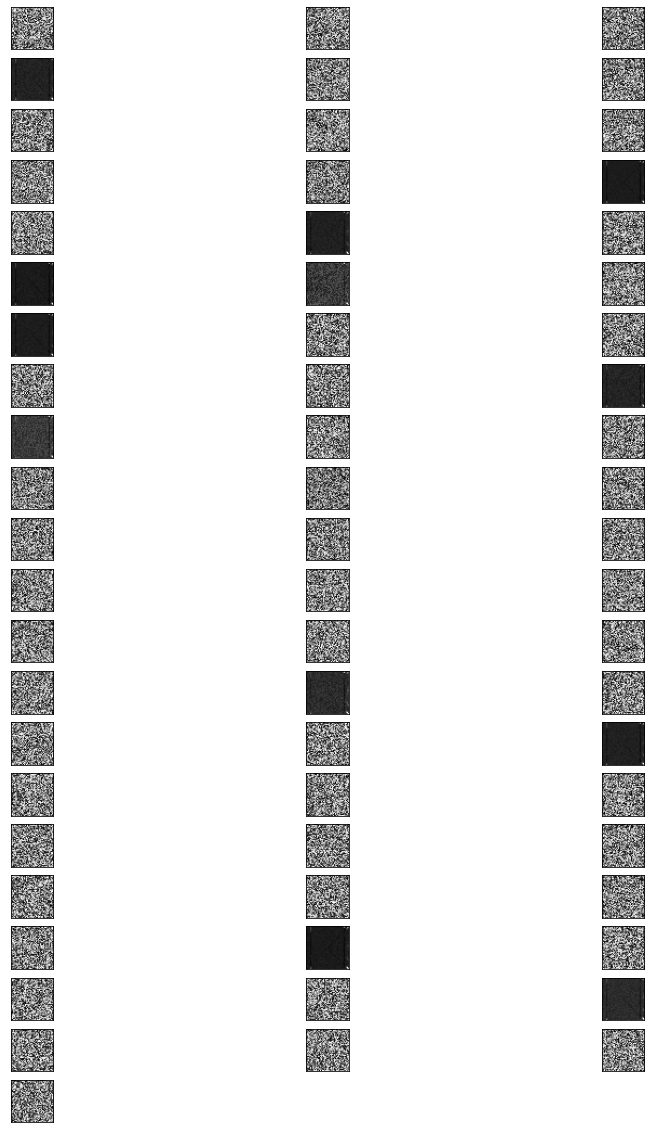

In [100]:
filters = model.layers[1].get_weights()
filters = filters[0]
f_min, f_max = np.min(filters), np.max(filters)
filters = (filters - f_min) / (f_max - f_min)

plt.figure(figsize=(15, 60))
# plot first few filters
n_filters, ix = 64, 1
for i in range(n_filters):
	# get the filter
	f = filters[:, :, :, i]
	# plot each channel separately
	for j in range(1):
		# specify subplot and turn of axis
		ax = plt.subplot(n_filters, 3, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(f[:, :, j], cmap='gray')
		ix += 1
# show the figure
plt.show()

In [101]:
filters

array([[[[0.10558295, 0.08976536, 0.10552065, ..., 0.11205558,
          0.1181405 , 0.10154346]],

        [[0.09175761, 0.11552072, 0.11362955, ..., 0.10137179,
          0.11415196, 0.10298353]],

        [[0.10452834, 0.09087199, 0.09944498, ..., 0.11441569,
          0.10458655, 0.10730512]],

        ...,

        [[0.09972551, 0.11656541, 0.11800107, ..., 0.09062408,
          0.09106039, 0.10203157]],

        [[0.10491328, 0.11509617, 0.09955047, ..., 0.11509556,
          0.09028044, 0.10184324]],

        [[0.10131835, 0.1019178 , 0.09980544, ..., 0.10950814,
          0.09955255, 0.09312606]]],


       [[[0.09421159, 0.09132151, 0.0884044 , ..., 0.11704896,
          0.10062888, 0.08936696]],

        [[0.11282605, 0.08741488, 0.1011637 , ..., 0.08765241,
          0.11398793, 0.09158173]],

        [[0.11524829, 0.09688652, 0.10390847, ..., 0.09585314,
          0.10806972, 0.08801541]],

        ...,

        [[0.11969738, 0.0974818 , 0.11449299, ..., 0.10573817,
       

In [41]:
model.layers[2]